In [1]:
import json
import sys, os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [46]:
directory = "data/online"

if not os.path.exists(directory):
    link = "https://www.dropbox.com/scl/fi/nkupgd6mfrxryefdoxxwn/20_30.zip?rlkey=dpwjhieorllwvavfh3le622t8&st=koo7vhx8&dl=1"
    import requests
    import zipfile
    import io

    r = requests.get(link)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(directory)

In [47]:
directory = "data/online/20_30"

# open all json files and parse them
data = []
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        with open(os.path.join(directory, filename)) as f:
            data.append(json.load(f))

In [48]:
# get all the policies
policies = set()
for d in data:
    policies.add(d["policies_names"][0])
policies = list(policies)
policies.sort()
index_policy = {k: i for i, k in enumerate(policies)}


Text(0.5, 0, 'Agent 1 policy')

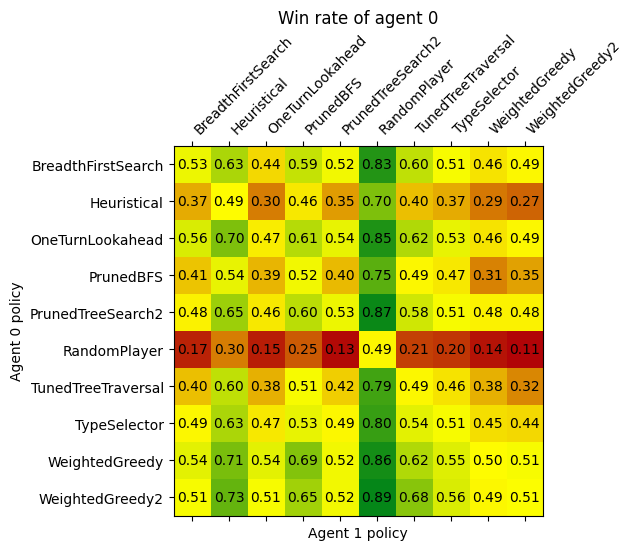

In [49]:
# WIN RATE
# map all data in the grid
# they all the combination of policies versus a different policy
# I want to map them in a grid showing the win rate

# create the grid
grid = np.zeros((len(policies), len(policies)))

for d in data:
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    # calculate the win rate
    wins = 0
    for battle in d["battles"]:
        if battle["result"] == 0:
            wins += 1
    grid[x, y] = wins / len(d["battles"])
    grid[y, x] = 1 - grid[x, y]

# Define the custom colormap
colors = ['#b10407', '#ffff00', '#058618']  # R -> Y -> G
n_bins = 100  # Discretize the interpolation into bins
cmap_name = 'r_y_g'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
n = len(policies)
fig, ax = plt.subplots()
cax = ax.matshow(grid, cmap=cm)
for i in range(n):
    for j in range(n):
        ax.text(j, i, f"{grid[i][j]:.2f}", ha='center', va='center', color='black')
plt.xticks(range(n), policies, rotation=45, ha='left')
plt.yticks(range(n), policies)
plt.title("Win rate of agent 0")
plt.ylabel("Agent 0 policy")
plt.xlabel("Agent 1 policy")


Text(0.5, 0, 'Agent 1 policy')

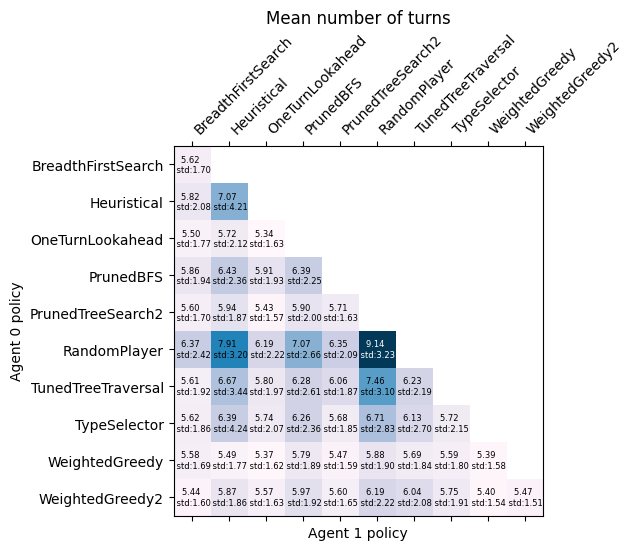

In [51]:
# MEAN NUMBER OF TURNS

turns = np.zeros((len(policies), len(policies)))
turns_dev = np.zeros((len(policies), len(policies)))

for d in data:
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    if x < y:
        x, y = y, x
    turns[y, x] = np.nan
    turns[x, y] = sum(battle["turns"] for battle in d["battles"])/d["n_battles_emulated"]
    turns_dev[y, x] = np.nan
    turns_dev[x, y] = np.std([battle["turns"] for battle in d["battles"]])


n = len(policies)
fig, ax = plt.subplots()
cax = ax.matshow(turns, cmap="PuBu")
for i in range(n):
    for j in range(n):
        if not np.isnan(turns[i, j]): 
            col = 'black'
            if turns[i, j] > 9: col = 'white'
            ax.text(j, i, f"{turns[i, j]:.2f} \n std:{turns_dev[i, j]:.2f}", ha='center', va='center', color=col, fontsize=6)
plt.xticks(range(n), policies, rotation=45, ha='left')
plt.yticks(range(n), policies)
plt.title("Mean number of turns")
plt.ylabel("Agent 0 policy")
plt.xlabel("Agent 1 policy")

Text(0.5, 0, 'Agent 1 policy')

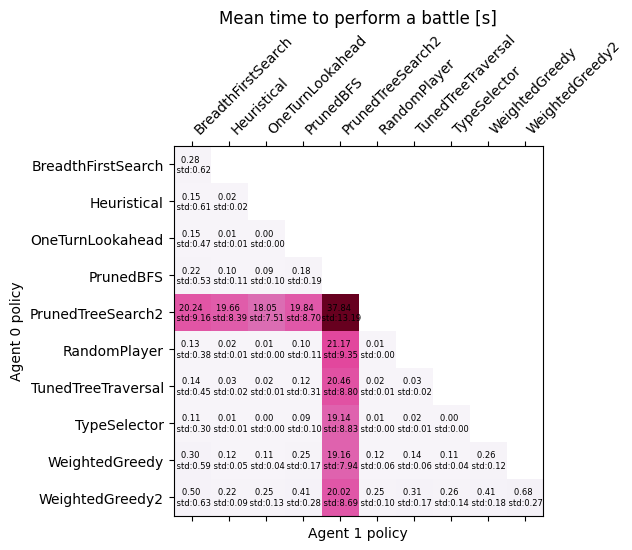

In [53]:
# MEAN TIME OF A BATTLE

time = np.zeros((len(policies), len(policies)))
time_dev = np.zeros((len(policies), len(policies)))

for d in data:
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    if x < y:
        x, y = y, x
    time[y, x] = np.nan
    time[x, y] = sum(battle["total_time"] for battle in d["battles"])/d["n_battles_emulated"]
    time_dev[y, x] = np.nan
    time_dev[x, y] = np.std([battle["total_time"] for battle in d["battles"]])

n = len(policies)
fig, ax = plt.subplots()
cax = ax.matshow(time, cmap="PuRd")
for i in range(n):
    for j in range(n):
        if not np.isnan(time[i, j]): 
            ax.text(j, i, f"{time[i, j]:.2f} \n std:{time_dev[i, j]:.2f}", ha='center', va='center', color='black', fontsize=6)
plt.xticks(range(n), policies, rotation=45, ha='left')
plt.yticks(range(n), policies)
plt.title("Mean time to perform a battle [s]")
plt.ylabel("Agent 0 policy")
plt.xlabel("Agent 1 policy")

C:\Users\matil\AppData\Local\Temp\ipykernel_19872\3932550102.py:44: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(d["policies_names"][0], d["policies_names"][1])


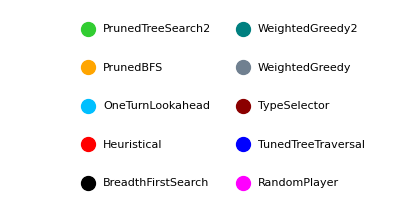

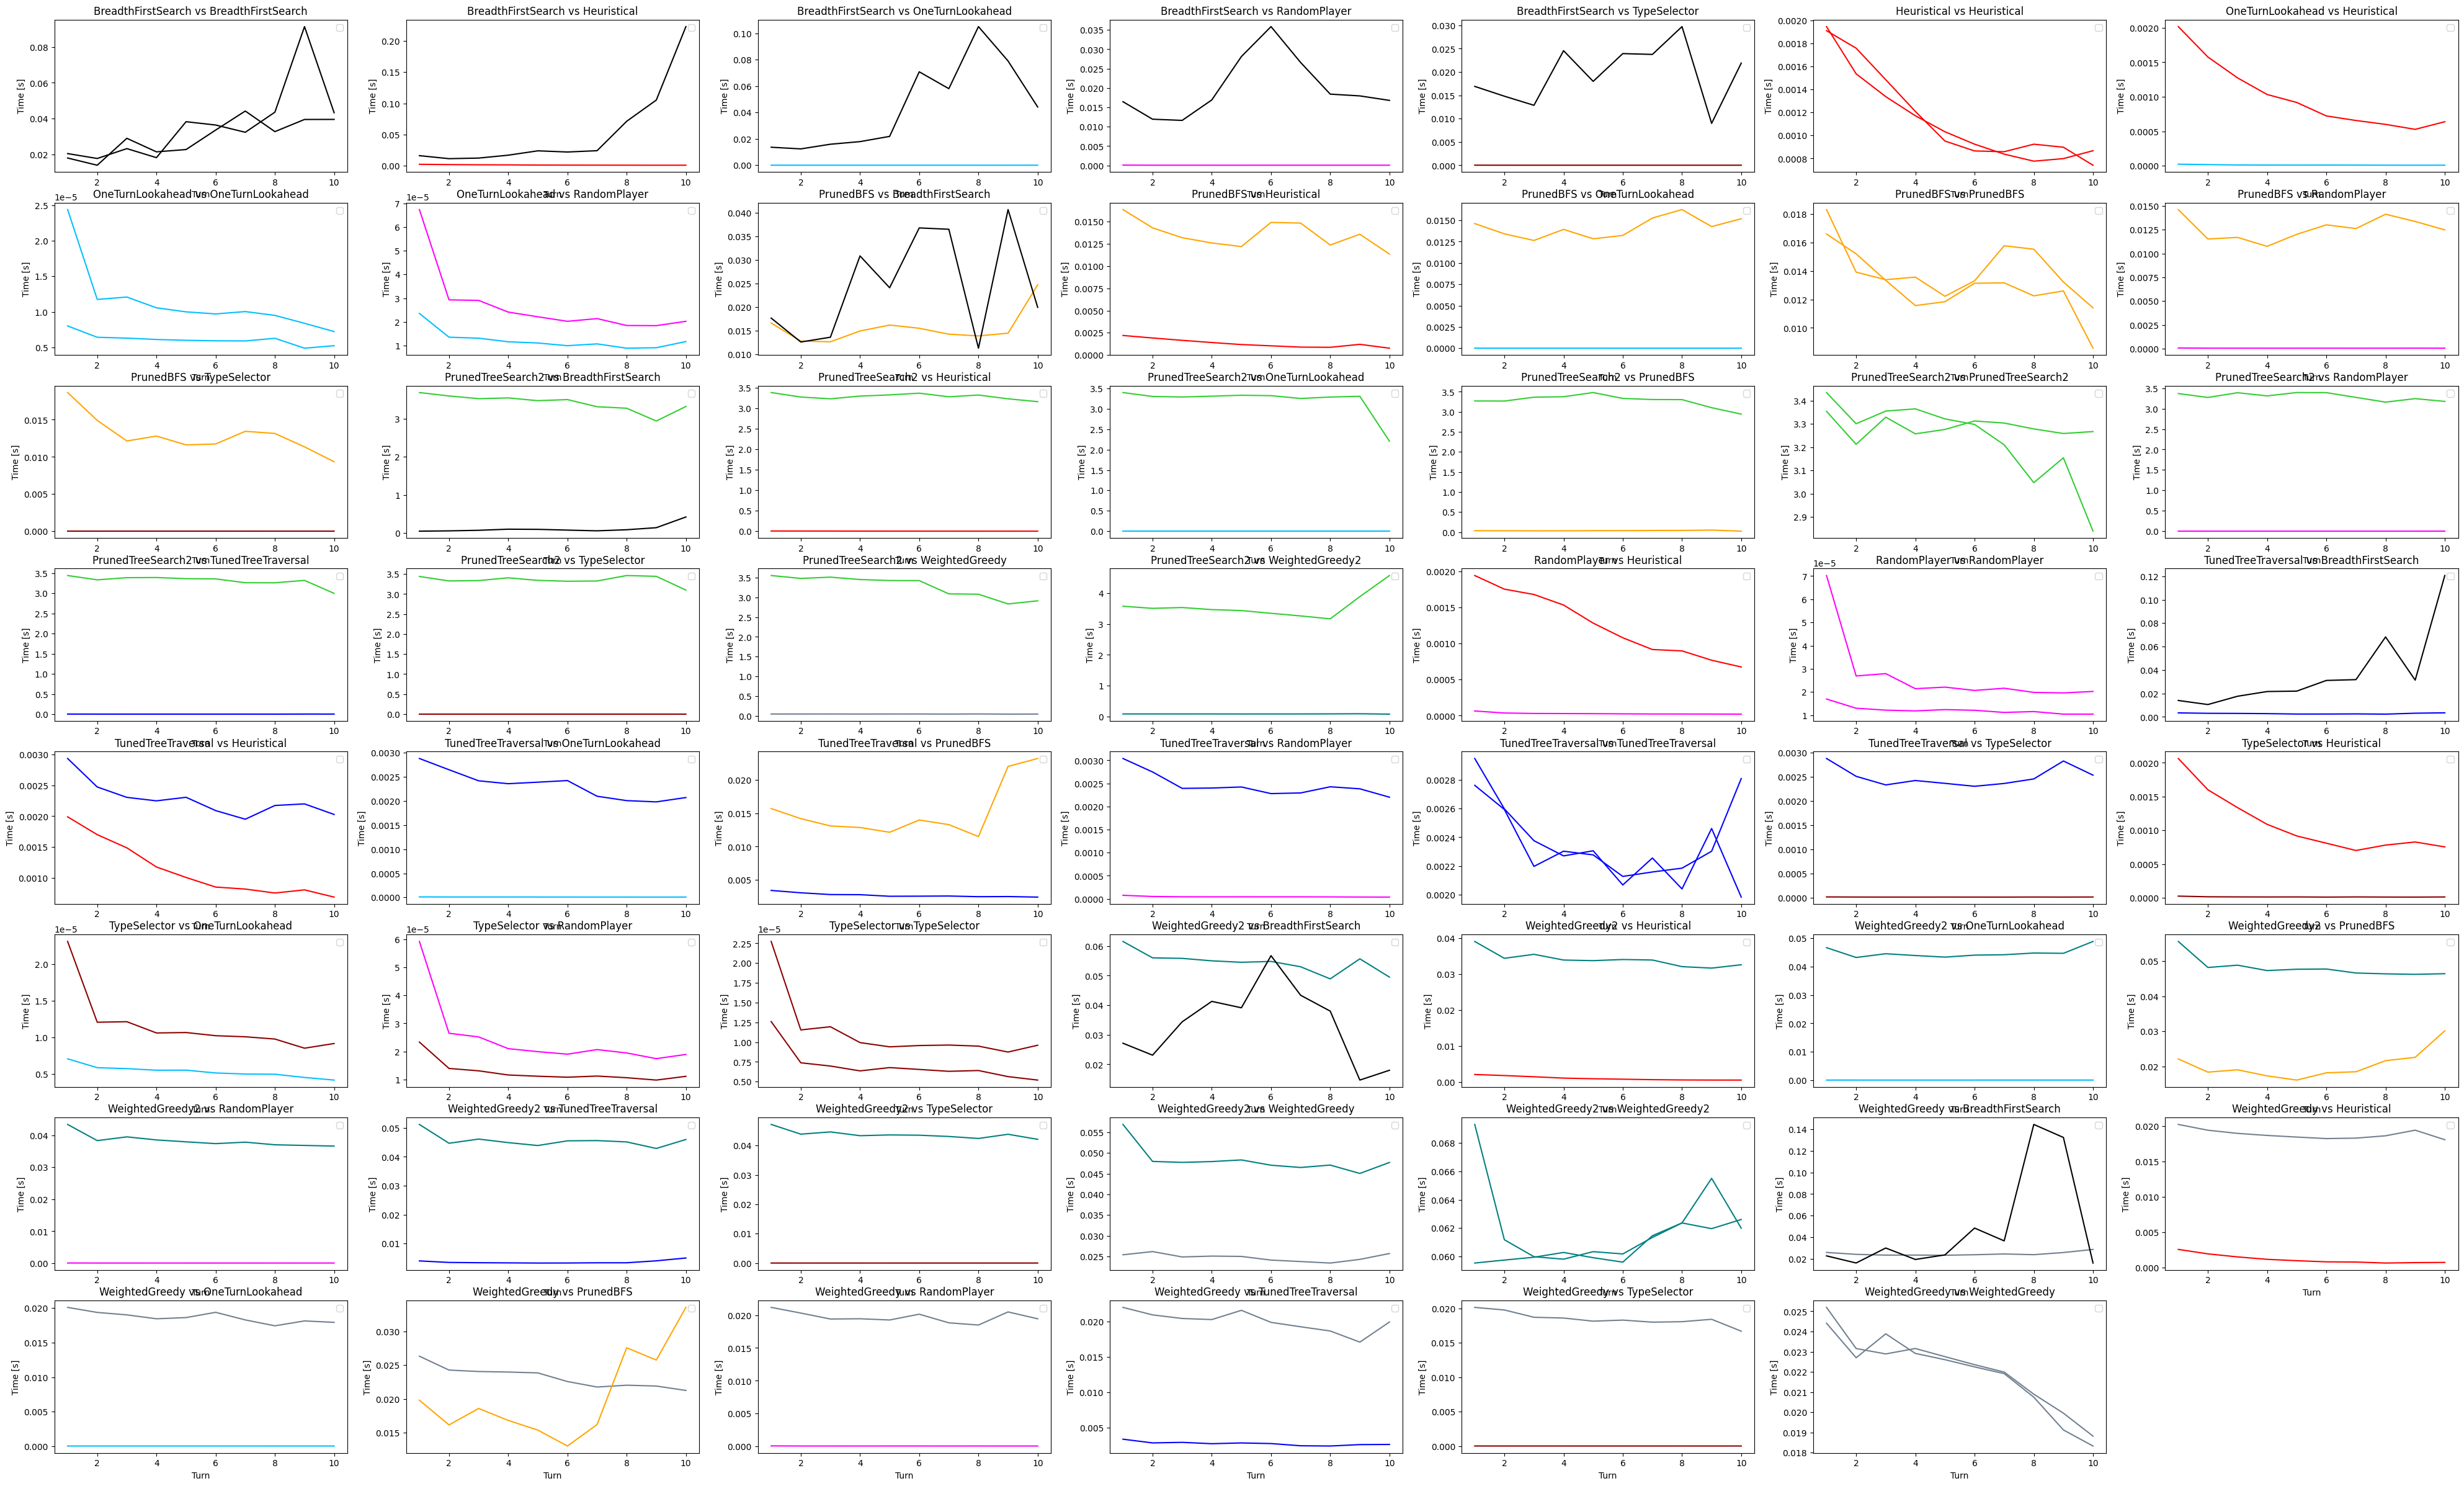

In [56]:
# MEAN TIME FOR EACH TURN 

# add relative parent directory to path
sys.path.append(os.path.dirname(os.getcwd()))

import utils.scraping_data as s

colors = ["black", "red", "deepskyblue", "orange", "limegreen", "magenta", "blue", "darkred", "slategray", "teal"]

num_rows = (len(colors) + 1) // 2  

plt.figure(figsize=(5, num_rows/2))  

for i, (color, label) in enumerate(zip(colors, policies)):
    col = i // num_rows  
    row = i % num_rows  

    plt.scatter(col, row, color=color, s=100)
    plt.text(col + 0.1, row, label, verticalalignment='center', fontsize=8)

plt.xlim(-0.5, 2)  
plt.ylim(-0.5, num_rows - 0.5)
plt.axis('off')  

n = len(policies)
tot_comb = n*(n+1)/2

n_col = int(np.floor(np.sqrt(tot_comb)))
n_row = int(np.ceil(tot_comb/n_col))

plt.figure(figsize=(50, 30))

for i, d in enumerate(data):
    avg_turn_time = s.get_avg_turn_time_per_turn(d, max_turn=10)
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    a = [x, y]

    plt.subplot(n_row, n_col, i+1)

    for j, p in enumerate(avg_turn_time):
        ax_x = range(1,len(p)+1)
        plt.plot(ax_x, p, color=colors[a[j]])
    
    plt.title(d["policies_names"][0]+ " vs " + d["policies_names"][1])
    plt.xlabel("Turn")
    plt.ylabel("Time [s]")


#plt.tight_layout
plt.show()

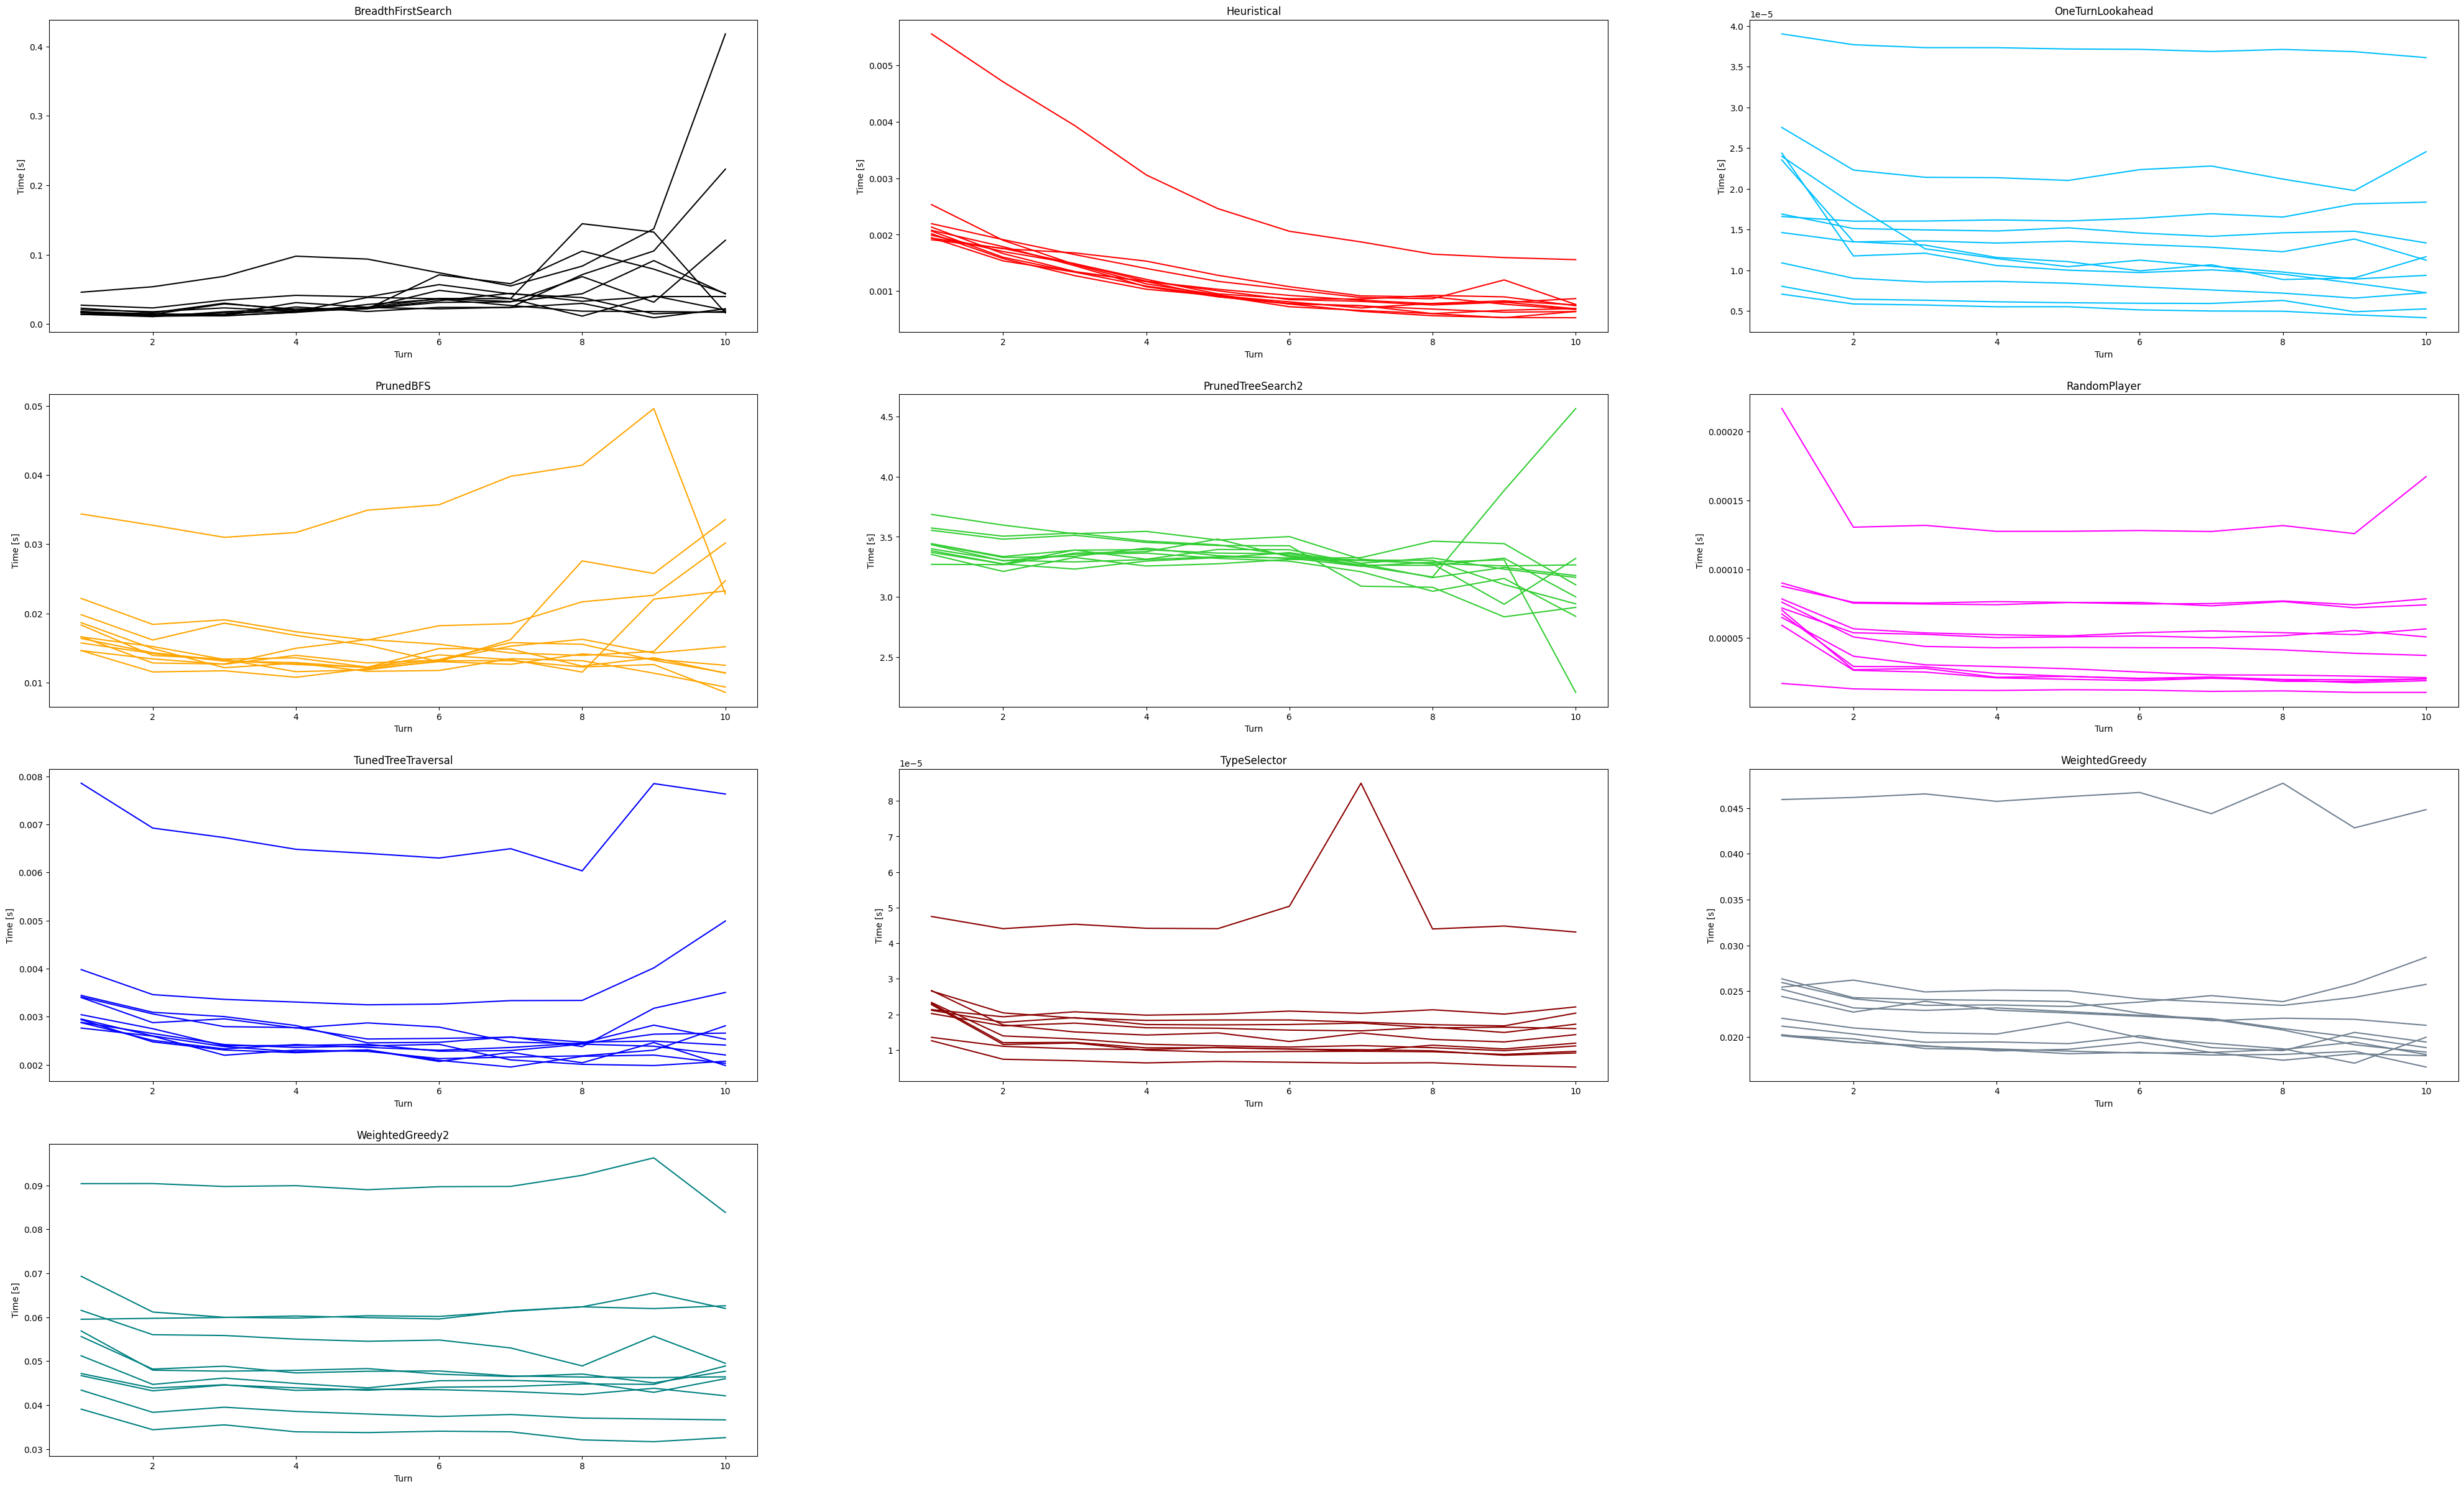

In [61]:
# MEAN TIME FOR EACH TURN - DIVIDED 

n_col = 3
n_row = int(np.ceil((n + 1) / n_col))


plt.figure(figsize=(50, 30))

for i, d in enumerate(data):
    avg_turn_time = s.get_avg_turn_time_per_turn(d, max_turn=10)
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    a = [x, y]

    for j, p in enumerate(avg_turn_time):
        ax_x = range(1,len(p)+1)
        plt.subplot(n_row, n_col, a[j]+1)
        plt.plot(ax_x, p, color=colors[a[j]])
        plt.title(d["policies_names"][j])
        plt.xlabel("Turn")
        plt.ylabel("Time [s]")
        
plt.show()